In [1]:
import os
import math
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

import seaborn as sns

from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

from PIL import Image

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms

from collections import Counter

from imblearn.over_sampling import RandomOverSampler

import pickle

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#Ucitavanje poadataka i uzimamo manji skup
data = pd.read_csv('kaggle/input/artemis-full/artemis.csv')
data = data[:1000]

In [4]:
data.head()

Unnamed: 0           art_style  \
0           0  Post_Impressionism   
1           1  Post_Impressionism   
2           2  Post_Impressionism   
3           3  Post_Impressionism   
4           4  Post_Impressionism   

                                            painting         emotion  \
0  vincent-van-gogh_portrait-of-madame-ginoux-l-a...  something else   
1  vincent-van-gogh_portrait-of-madame-ginoux-l-a...         sadness   
2  vincent-van-gogh_portrait-of-madame-ginoux-l-a...  something else   
3  vincent-van-gogh_portrait-of-madame-ginoux-l-a...     contentment   
4  vincent-van-gogh_portrait-of-madame-ginoux-l-a...             awe   

                                           utterance  repetition  \
0  She seems very happy in the picture, and you w...          10   
1  This woman has really knotty hands which makes...          10   
2  When looking at this woman, I am filled with c...          10   
3  A woman looking at ease, peaceful, and satisfi...          10   
4  She looks like a lady from that past that migh...          10   

                                                path  
0  /kaggle/input/wikiart/Post_Impressionism/vince...  
1  /kaggle/input/wikiart/Post_Impressionism/vince...  
2  /kaggle/input/wikiart/Post_Impressionism/vince...  
3  /kaggle/input/wikiart/Post_Impressionism/vince...  
4  /kaggle/input/wikiart/Post_Impressionism/vince...

In [5]:
data.shape

(1000, 7)

In [6]:
#Manjemo outanju do fajla tako da odgovara nasoj lokalnoj
correct_path_prefix = 'kaggle/input/wikiart/'
def update_path(path):
    return path.replace('/kaggle/input/wikiart/', correct_path_prefix)

data['path'] = data['path'].apply(update_path)

In [7]:
def plot_images_with_emotions_grid(df, num_images=10, columns=5):
    rows = math.ceil(num_images / columns) 
    fig, axes = plt.subplots(rows, columns, figsize=(20, 4 * rows)) 
    axes = axes.flatten()
    
    for i, (index, row) in enumerate(df.iterrows()):
        if i >= num_images:
            break
        try:
            img = mpimg.imread(row['path'])
            axes[i].imshow(img)
            axes[i].set_title(f"Emocija: {row['emotion']}")
            axes[i].axis('off')
        except FileNotFoundError:
            print(f"Slika nije pronađena na putanji {row['path']}")
            axes[i].axis('off')
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

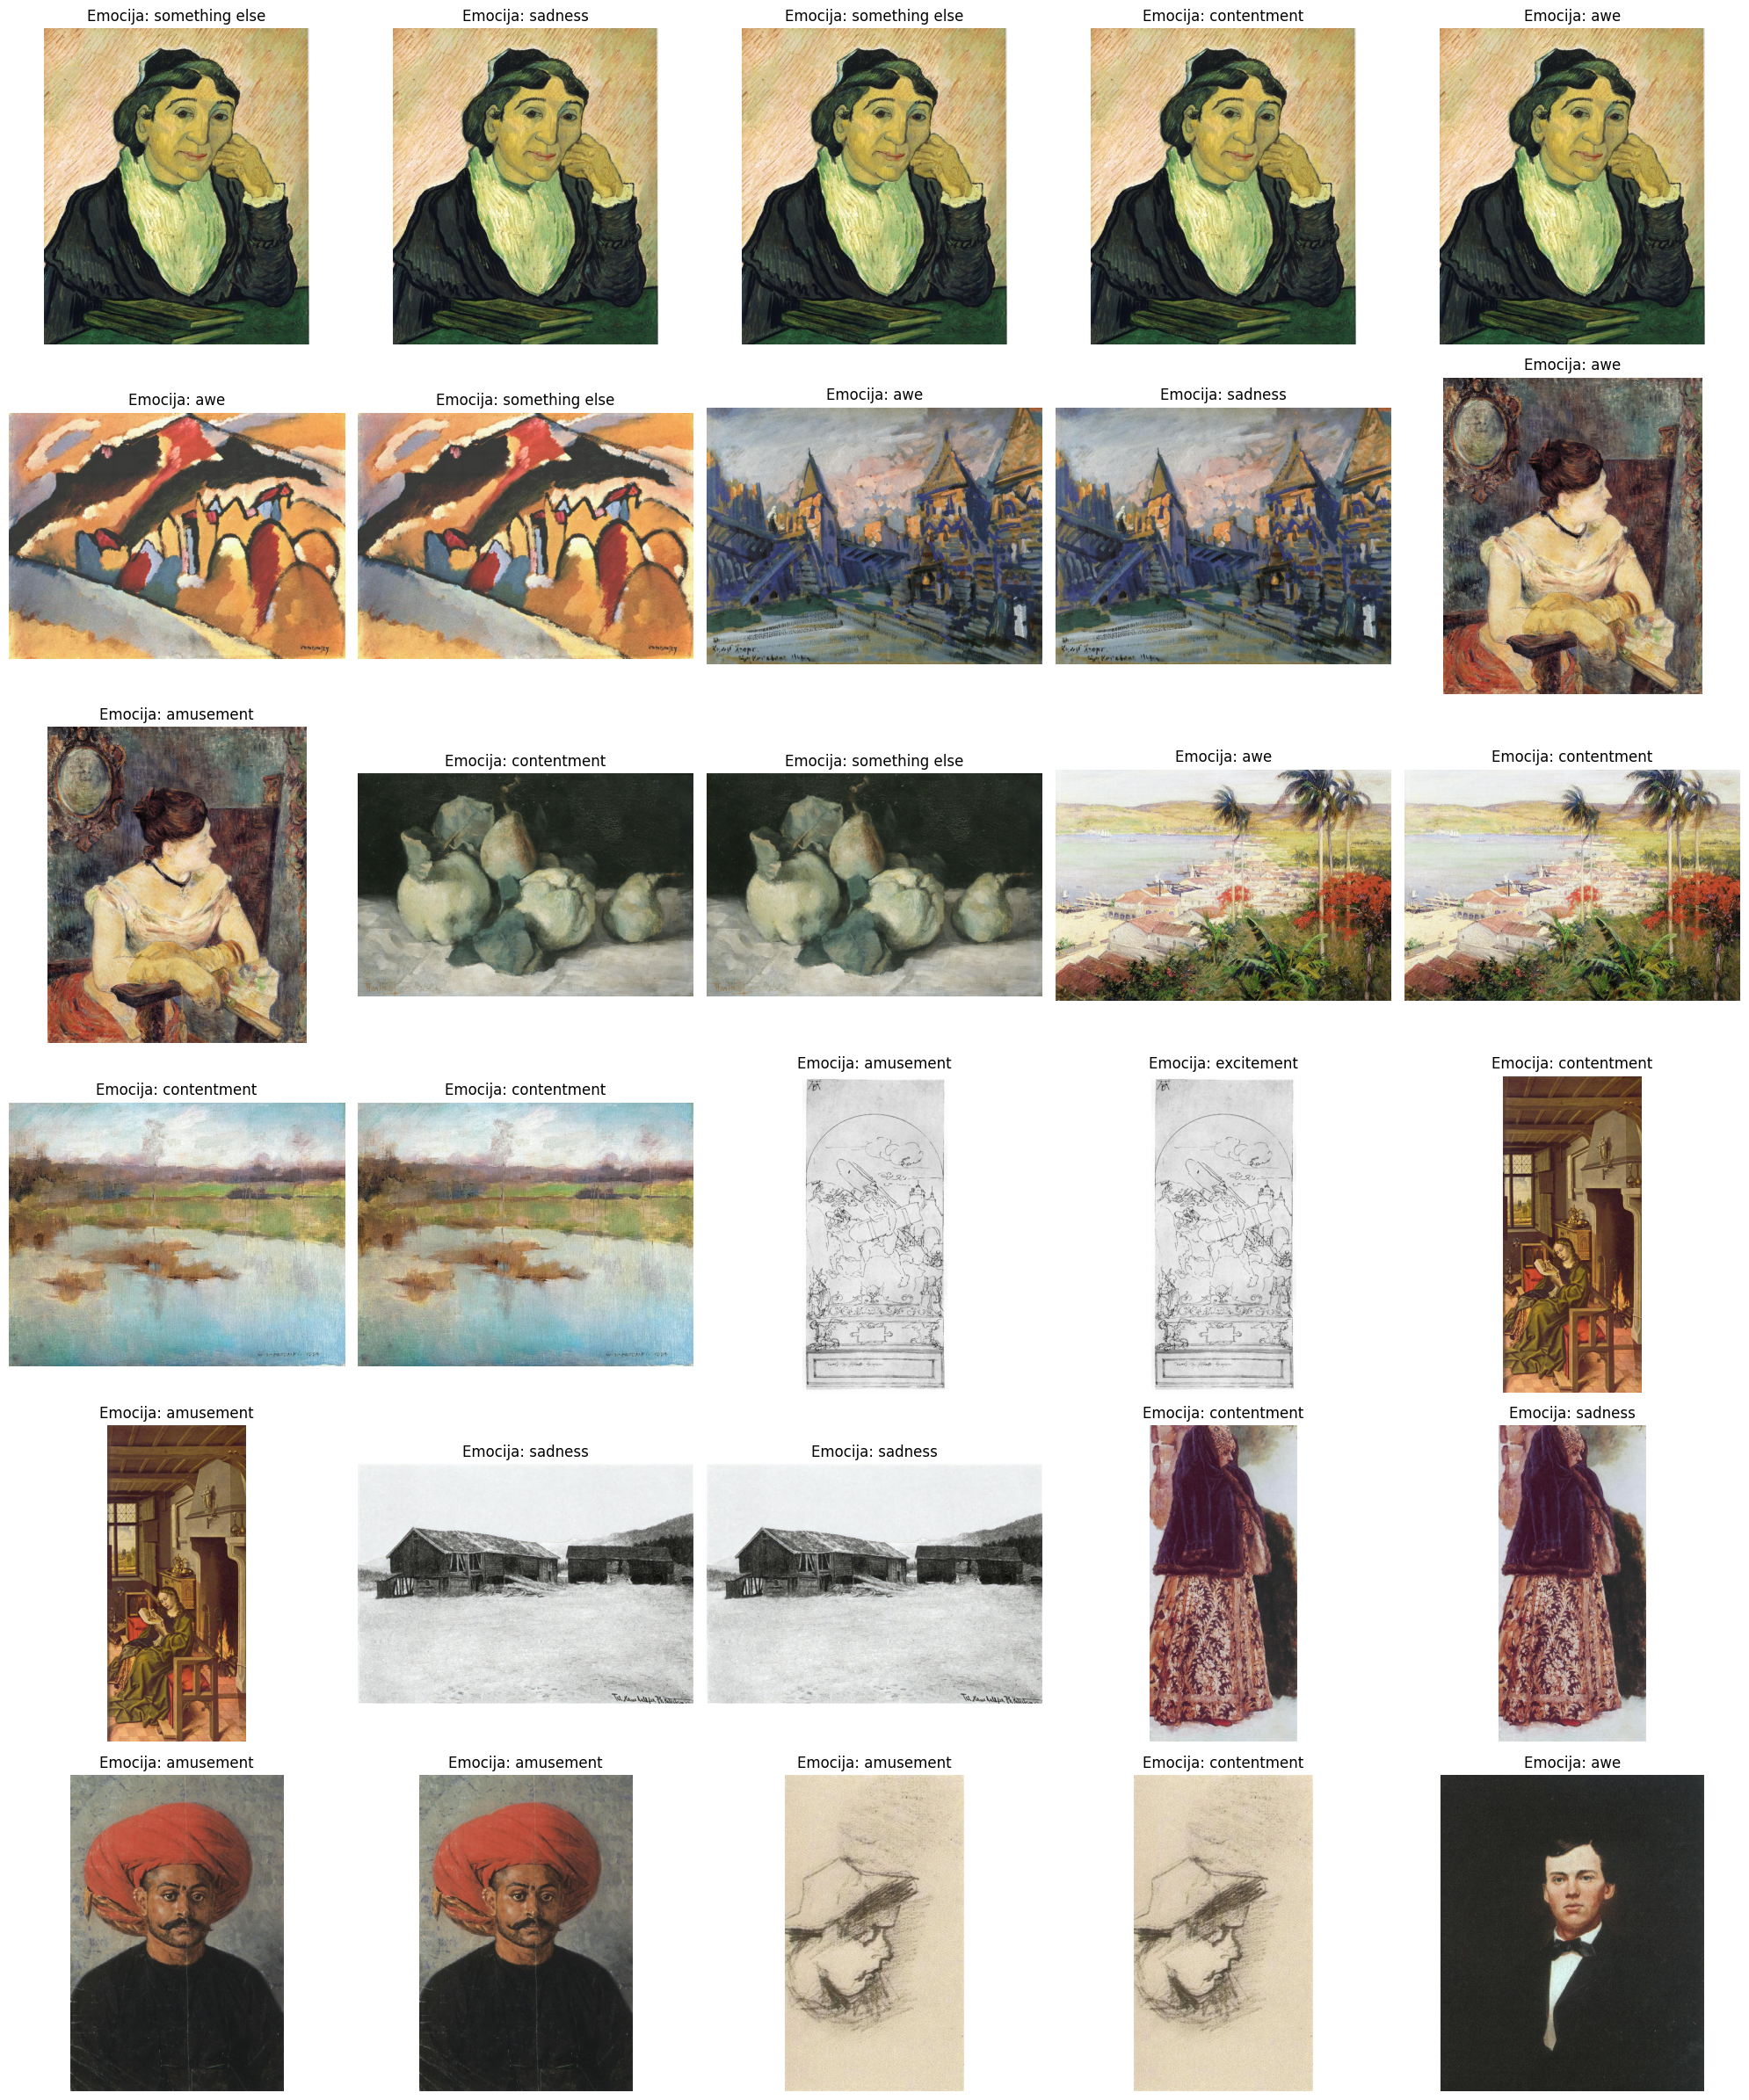

In [8]:
plot_images_with_emotions_grid(data, num_images=30)

In [9]:
#Zastupljenost emocija
data['emotion'].value_counts()

emotion
contentment       328
awe               218
sadness           117
amusement         109
fear               92
excitement         62
disgust            37
something else     31
anger               6
Name: count, dtype: int64

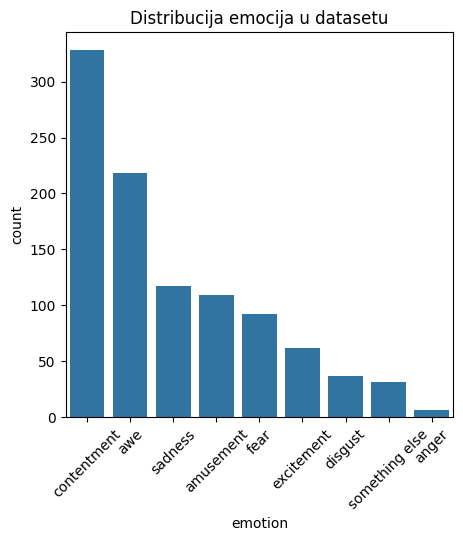

In [10]:
plt.figure(figsize=(5,5))
sns.countplot(x='emotion', data=data, order=data['emotion'].value_counts().index)
plt.title('Distribucija emocija u datasetu')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Grupisanje emocija po slikama
data_grouped = data.groupby('path')['emotion'].apply(list).reset_index()

# Dobijanje putanja i emocija
image_paths = data_grouped['path'].values
emotions = data_grouped['emotion'].values


# Proveravamo da li broj slika i broj emocija odgovara
print(f"Broj slika: {len(image_paths)}, Broj emocionalnih zapisa: {len(emotions)}")

# Pretvaranje emocija u binarne vrednosti pomoću OneHotEncoder
onehot_encoder = preprocessing.MultiLabelBinarizer()
emotions_encoded = onehot_encoder.fit_transform(emotions)

# Provera enkodiranih emocija
print("Prvih nekoliko zapisa emocija nakon enkodiranja:")
print(emotions_encoded[:5])


Broj slika: 980, Broj emocionalnih zapisa: 980
Prvih nekoliko zapisa emocija nakon enkodiranja:
[[0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]]


In [12]:
# Brojanje učestalosti svake kombinacije emocija
emotion_counts = Counter([tuple(encoding) for encoding in emotions_encoded])

# Prikazujemo trenutnu distribuciju kombinacija emocija pre oversamplinga
print(f"Trenutna distribucija pre naduzorkovanja: {dict(emotion_counts)}")

# Maksimalna učestalost bilo koje kombinacije
max_count = max(emotion_counts.values())

# oversampling tako da sve kombinacije imaju istu učestalost
X_resampled = []
y_resampled = []

Trenutna distribucija pre naduzorkovanja: {(0, 1, 0, 0, 0, 0, 0, 0, 0): 6, (0, 0, 0, 0, 0, 0, 0, 0, 1): 27, (0, 0, 0, 0, 0, 1, 0, 0, 0): 61, (0, 0, 0, 1, 0, 0, 0, 0, 0): 320, (0, 0, 0, 0, 0, 0, 1, 0, 0): 91, (0, 0, 0, 0, 1, 0, 0, 0, 0): 37, (1, 0, 0, 0, 0, 0, 0, 0, 0): 104, (0, 0, 1, 0, 0, 0, 0, 0, 0): 210, (0, 0, 0, 0, 0, 0, 0, 1, 0): 113, (0, 0, 1, 0, 0, 0, 0, 0, 1): 1, (0, 0, 1, 1, 0, 0, 0, 0, 0): 2, (0, 0, 1, 0, 0, 0, 0, 1, 0): 1, (1, 0, 1, 0, 0, 0, 0, 0, 0): 1, (0, 0, 0, 1, 0, 0, 0, 0, 1): 1, (1, 0, 0, 0, 0, 1, 0, 0, 0): 1, (1, 0, 0, 1, 0, 0, 0, 0, 0): 2, (0, 0, 1, 1, 0, 0, 0, 1, 1): 1, (0, 0, 0, 1, 0, 0, 0, 1, 0): 1}


In [13]:

for emotion_tuple, count in emotion_counts.items():
    indices = [i for i, encoding in enumerate(emotions_encoded) if tuple(encoding) == emotion_tuple]
    
    # Ako je potrebno više uzoraka, dodajemo ih
    num_samples_needed = max_count - count
    if num_samples_needed > 0:
        # Ponavljamo uzorke da bismo dobili dovoljno podataka
        resample_indices = np.random.choice(indices, num_samples_needed, replace=True)
        X_resampled.extend([image_paths[i] for i in resample_indices])
        y_resampled.extend([emotions_encoded[i] for i in resample_indices])
    
    # Dodajemo originalne uzorke
    X_resampled.extend([image_paths[i] for i in indices])
    y_resampled.extend([emotions_encoded[i] for i in indices])

# Proveravamo veličine nakon oversampling
print(f"Originalna veličina: {len(image_paths)}")
print(f"Veličina nakon ručnog naduzorkovanja: {len(X_resampled)}")

# Ispisivanje distribucije kombinacija emocija nakon ručnog oversamplinga
resampled_emotion_counts = Counter([tuple(encoding) for encoding in y_resampled])
print(f"Distribucija kombinacija emocija nakon ručnog naduzorkovanja: {dict(resampled_emotion_counts)}")


Originalna veličina: 980
Veličina nakon ručnog naduzorkovanja: 5760
Distribucija kombinacija emocija nakon ručnog naduzorkovanja: {(0, 1, 0, 0, 0, 0, 0, 0, 0): 320, (0, 0, 0, 0, 0, 0, 0, 0, 1): 320, (0, 0, 0, 0, 0, 1, 0, 0, 0): 320, (0, 0, 0, 1, 0, 0, 0, 0, 0): 320, (0, 0, 0, 0, 0, 0, 1, 0, 0): 320, (0, 0, 0, 0, 1, 0, 0, 0, 0): 320, (1, 0, 0, 0, 0, 0, 0, 0, 0): 320, (0, 0, 1, 0, 0, 0, 0, 0, 0): 320, (0, 0, 0, 0, 0, 0, 0, 1, 0): 320, (0, 0, 1, 0, 0, 0, 0, 0, 1): 320, (0, 0, 1, 1, 0, 0, 0, 0, 0): 320, (0, 0, 1, 0, 0, 0, 0, 1, 0): 320, (1, 0, 1, 0, 0, 0, 0, 0, 0): 320, (0, 0, 0, 1, 0, 0, 0, 0, 1): 320, (1, 0, 0, 0, 0, 1, 0, 0, 0): 320, (1, 0, 0, 1, 0, 0, 0, 0, 0): 320, (0, 0, 1, 1, 0, 0, 0, 1, 1): 320, (0, 0, 0, 1, 0, 0, 0, 1, 0): 320}


In [14]:
# ISPIŠIMO SADA KOJE KLASE IMAMO:

# Preuzimanje imena emocija
emotion_labels = onehot_encoder.classes_

# Ispisivanje svake kombinacije emocija zajedno sa njihovim binarnim vektorima
print("Klase nakon naduzorkovanja (kombinacije emocija):\n")
for combination in resampled_emotion_counts:
    emotion_names = [emotion_labels[i] for i, val in enumerate(combination) if val == 1]
    print(f"Kombinacija: {combination} -> Emocije: {', '.join(emotion_names) if emotion_names else 'Nema emocija'}")


Klase nakon naduzorkovanja (kombinacije emocija):

Kombinacija: (0, 1, 0, 0, 0, 0, 0, 0, 0) -> Emocije: anger
Kombinacija: (0, 0, 0, 0, 0, 0, 0, 0, 1) -> Emocije: something else
Kombinacija: (0, 0, 0, 0, 0, 1, 0, 0, 0) -> Emocije: excitement
Kombinacija: (0, 0, 0, 1, 0, 0, 0, 0, 0) -> Emocije: contentment
Kombinacija: (0, 0, 0, 0, 0, 0, 1, 0, 0) -> Emocije: fear
Kombinacija: (0, 0, 0, 0, 1, 0, 0, 0, 0) -> Emocije: disgust
Kombinacija: (1, 0, 0, 0, 0, 0, 0, 0, 0) -> Emocije: amusement
Kombinacija: (0, 0, 1, 0, 0, 0, 0, 0, 0) -> Emocije: awe
Kombinacija: (0, 0, 0, 0, 0, 0, 0, 1, 0) -> Emocije: sadness
Kombinacija: (0, 0, 1, 0, 0, 0, 0, 0, 1) -> Emocije: awe, something else
Kombinacija: (0, 0, 1, 1, 0, 0, 0, 0, 0) -> Emocije: awe, contentment
Kombinacija: (0, 0, 1, 0, 0, 0, 0, 1, 0) -> Emocije: awe, sadness
Kombinacija: (1, 0, 1, 0, 0, 0, 0, 0, 0) -> Emocije: amusement, awe
Kombinacija: (0, 0, 0, 1, 0, 0, 0, 0, 1) -> Emocije: contentment, something else
Kombinacija: (1, 0, 0, 0, 0, 1, 0, 

In [15]:
# Podela na tren, validacioni i test set
image_paths_train, image_paths_temp, y_train, y_temp = model_selection.train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=7
)
image_paths_val, image_paths_test, y_val, y_test = model_selection.train_test_split(
    image_paths_temp, y_temp, test_size=0.5, random_state=7
)


In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Horizontalno rotiranje slika
    transforms.RandomRotation(10),  # Nasumična rotacija do 10 stepeni
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [17]:
# Klasa za dataset
class ArtDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths  # Putanje do slika
        self.labels = labels  # Binarni vektori emocija (višelabelske oznake)
        self.transform = transform  # Transformacije za slike
    
    def __len__(self):
        return len(self.image_paths)  # Broj slika
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Učitavanje slike
        
        if self.transform:
            image = self.transform(image)  # Primena transformacija (npr. normalizacija)
        
        label = self.labels[idx]  # Binarni vektor emocija (etikete)
        return image, label  # Vraća sliku i pripadajuće oznake

In [18]:
# Kreiranje dataset-a za treniranje i validaciju
train_dataset = ArtDataset(image_paths_train, y_train, transform=transform)
val_dataset = ArtDataset(image_paths_val, y_val, transform=transform)
test_dataset = ArtDataset(image_paths_test, y_test, transform=transform)

# Kreiranje DataLoader-a za treniranje i validaciju
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [19]:
# MODEL ZA VIŠELABELSKU KLASIFIKACIJU SA RESNET-OM

# Koristimo pretrenirani ResNet
class MultiLabelResNet(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)  # Koristimo ResNet-18
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # Prilagođavamo izlazni sloj

    def forward(self, x):
        return self.resnet(x)


num_classes = emotions_encoded.shape[1]
modelResNet = MultiLabelResNet(num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(modelResNet.parameters(), lr=0.0001, weight_decay=1e-5)

/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
def train_classification(model, criterion, optimizer, number_of_epochs, train_loader, validation_loader):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(number_of_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())  # BCEWithLogitsLoss očekuje float
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted = (outputs > 0.5).float()  
            correct += (predicted == labels).sum().item()
            total += labels.numel()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        print(f"Epoch [{epoch + 1}/{number_of_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")

        if validation_loader:
            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for val_inputs, val_labels in validation_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs, val_labels.float())
                    val_running_loss += val_loss.item()

                    val_predicted = (val_outputs > 0.5).float() 
                    val_correct += (val_predicted == val_labels).sum().item()
                    val_total += val_labels.numel()

            epoch_val_loss = val_running_loss / len(validation_loader)
            epoch_val_accuracy = val_correct / val_total
            val_losses.append(epoch_val_loss)
            val_accuracies.append(epoch_val_accuracy)
            print(f"Epoch [{epoch + 1}/{number_of_epochs}], Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [21]:
train_losses, train_accuracies, val_losses, val_accuracies = train_classification(
    modelResNet, criterion, optimizer, number_of_epochs=10, 
    train_loader=train_loader, validation_loader=val_loader
) 

Epoch [1/10], Train Loss: 0.2016, Train Accuracy: 0.9438
Epoch [1/10], Validation Loss: 0.1009, Validation Accuracy: 0.9641
Epoch [2/10], Train Loss: 0.0754, Train Accuracy: 0.9750
Epoch [2/10], Validation Loss: 0.0637, Validation Accuracy: 0.9823
Epoch [3/10], Train Loss: 0.0383, Train Accuracy: 0.9892
Epoch [3/10], Validation Loss: 0.0514, Validation Accuracy: 0.9836
Epoch [4/10], Train Loss: 0.0217, Train Accuracy: 0.9950
Epoch [4/10], Validation Loss: 0.0478, Validation Accuracy: 0.9865
Epoch [5/10], Train Loss: 0.0131, Train Accuracy: 0.9974
Epoch [5/10], Validation Loss: 0.0515, Validation Accuracy: 0.9873
Epoch [6/10], Train Loss: 0.0092, Train Accuracy: 0.9985
Epoch [6/10], Validation Loss: 0.0453, Validation Accuracy: 0.9859
Epoch [7/10], Train Loss: 0.0055, Train Accuracy: 0.9994
Epoch [7/10], Validation Loss: 0.0463, Validation Accuracy: 0.9875
Epoch [8/10], Train Loss: 0.0046, Train Accuracy: 0.9994
Epoch [8/10], Validation Loss: 0.0495, Validation Accuracy: 0.9878
Epoch [9

In [22]:
def plot_classification(train_loss, train_accuracy, val_loss, val_accuracy):
    number_of_epochs = len(train_loss)
    epochs = range(1, number_of_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plotting Training Loss
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epochs, train_loss, label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, label='Validation Loss')

    plt.legend()

    # Plotting Training Accuracy
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    if val_accuracy:
        plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

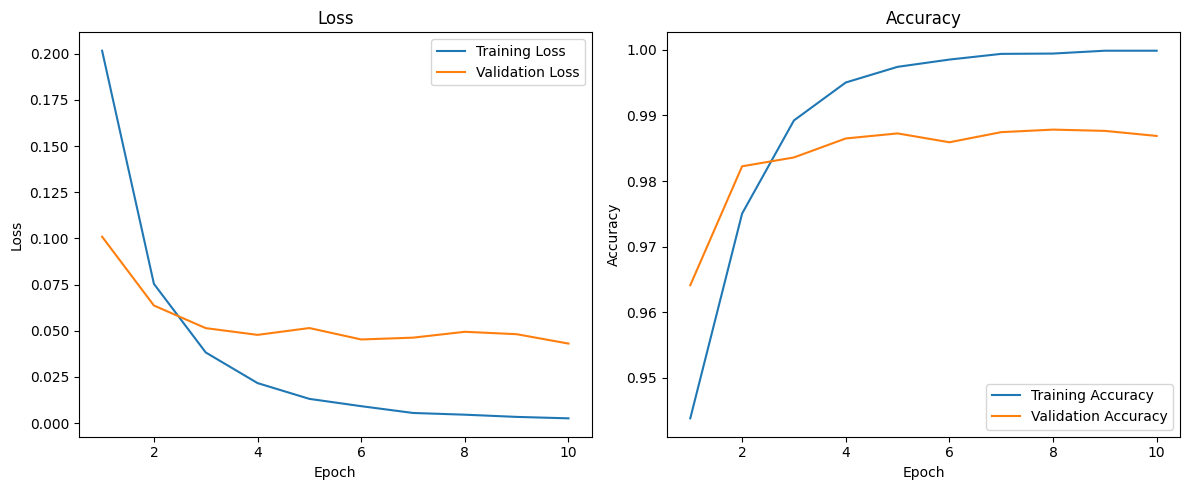

In [23]:
plot_classification(train_losses, train_accuracies, val_losses, val_accuracies)

In [24]:
def evaluate_classification(model, criterion, loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    predicted_labels, true_labels = [], []

    with torch.no_grad():  
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            total_loss += criterion(outputs, labels.float()).item()  # BCEWithLogitsLoss očekuje float


            predicted = (outputs > 0.5).float()
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.ey())

            total_samples += labels.numel() 
            total_correct += (predicted == labels).sum().item()


    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
    
    print(f'Model evaluation on: {loader}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    cm = multilabel_confusion_matrix(true_labels, predicted_labels)
    for idx, (conf_matrix, emotion) in enumerate(zip(cm, onehot_encoder.classes_)):
        plt.figure(figsize=(5, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for Emotion: {emotion}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x7f719476d370>
Accuracy: 0.9253
Precision: 0.9898
Recall: 0.9758
F1 Score: 0.9825


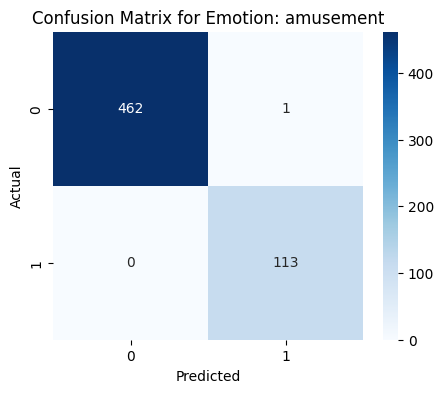

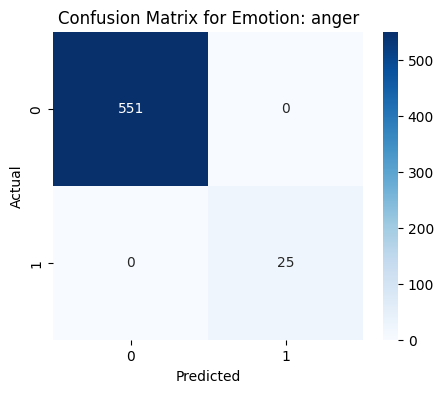

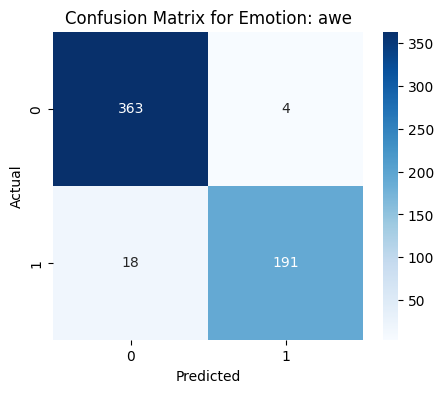

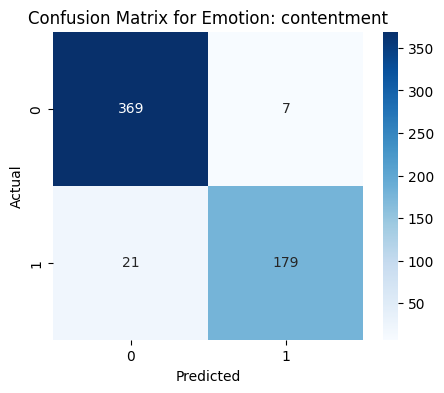

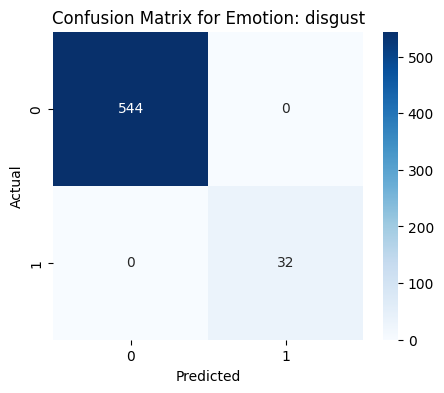

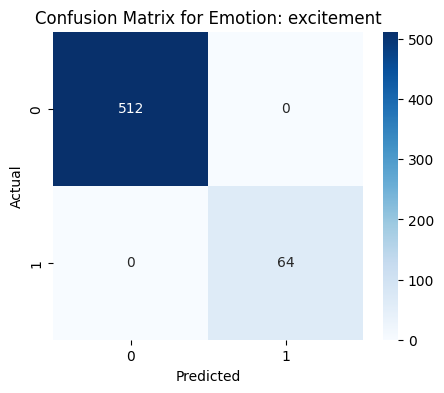

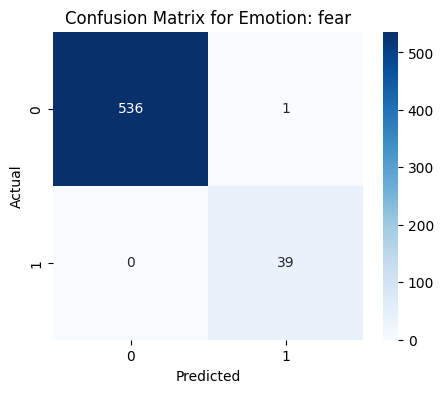

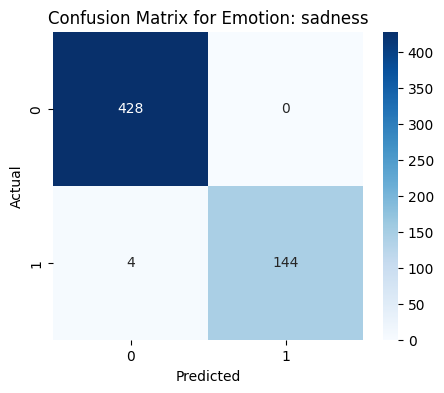

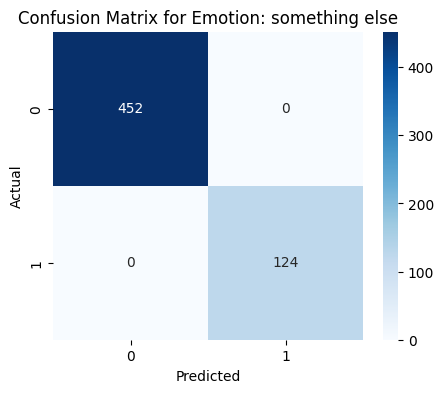

Train Set: Loss: 0.0436, Accuracy: 0.9892


In [25]:
test_loss, test_accuracy = evaluate_classification(modelResNet, criterion, test_loader)
print(f'Train Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')

In [26]:
def create_alexnet_model(num_classes):
    model = models.alexnet(pretrained=True)
    # Zamenjujemo poslednji sloj sa slojem za broj klasa
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
    
    return model

In [27]:
num_classes = emotions_encoded.shape[1] 
alexNetModel = create_alexnet_model(num_classes).to(device)

/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(alexNetModel.parameters(), lr=0.0001)

train_losses, train_accuracies, val_losses, val_accuracies = train_classification(
    alexNetModel, criterion, optimizer, number_of_epochs=10, 
    train_loader=train_loader, validation_loader=val_loader
)


Epoch [1/10], Train Loss: 0.1593, Train Accuracy: 0.9441
Epoch [1/10], Validation Loss: 0.1054, Validation Accuracy: 0.9674
Epoch [2/10], Train Loss: 0.0752, Train Accuracy: 0.9717
Epoch [2/10], Validation Loss: 0.0614, Validation Accuracy: 0.9778
Epoch [3/10], Train Loss: 0.0472, Train Accuracy: 0.9818
Epoch [3/10], Validation Loss: 0.0530, Validation Accuracy: 0.9838
Epoch [4/10], Train Loss: 0.0296, Train Accuracy: 0.9886
Epoch [4/10], Validation Loss: 0.0475, Validation Accuracy: 0.9846
Epoch [5/10], Train Loss: 0.0194, Train Accuracy: 0.9924
Epoch [5/10], Validation Loss: 0.0490, Validation Accuracy: 0.9867
Epoch [6/10], Train Loss: 0.0156, Train Accuracy: 0.9944
Epoch [6/10], Validation Loss: 0.0432, Validation Accuracy: 0.9875
Epoch [7/10], Train Loss: 0.0132, Train Accuracy: 0.9949
Epoch [7/10], Validation Loss: 0.0515, Validation Accuracy: 0.9867
Epoch [8/10], Train Loss: 0.0105, Train Accuracy: 0.9958
Epoch [8/10], Validation Loss: 0.0519, Validation Accuracy: 0.9875
Epoch [9

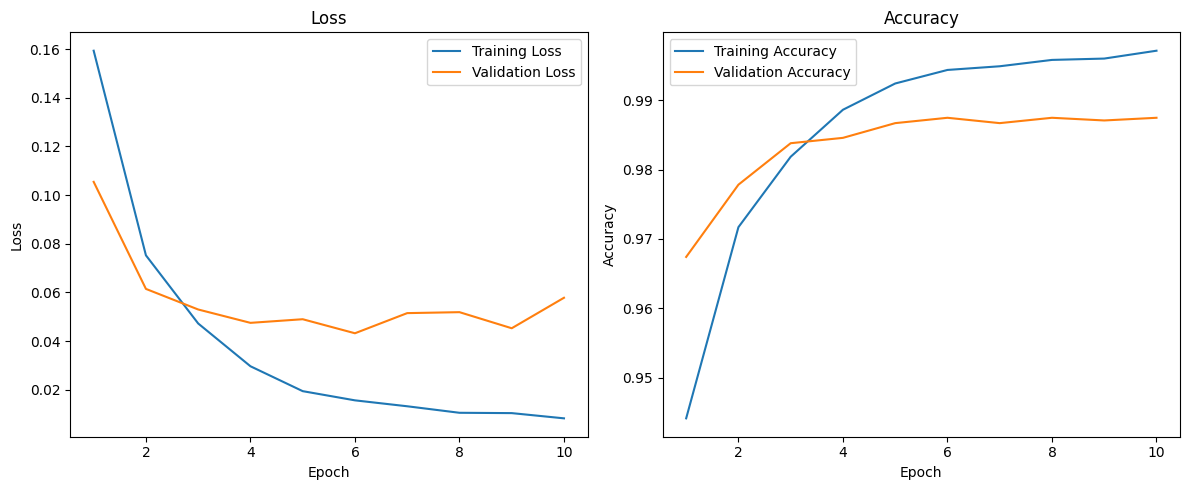

In [29]:
plot_classification(train_losses, train_accuracies, val_losses, val_accuracies)

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x7f719476d370>
Accuracy: 0.9045
Precision: 0.9763
Recall: 0.9707
F1 Score: 0.9725


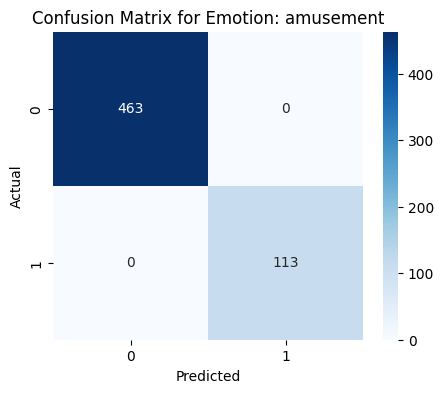

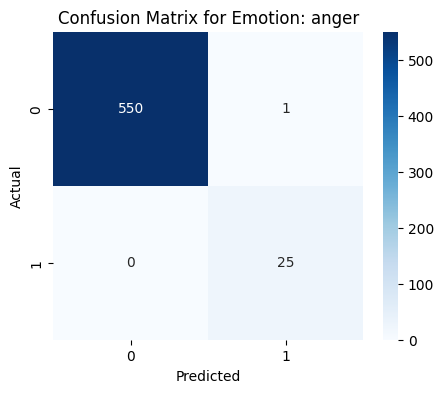

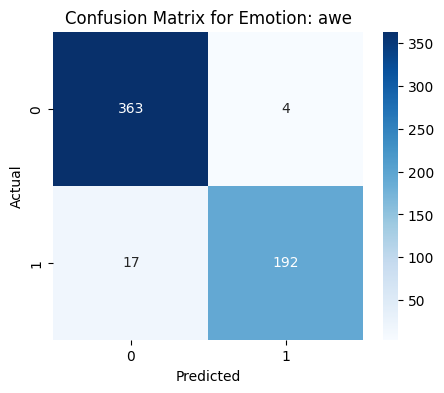

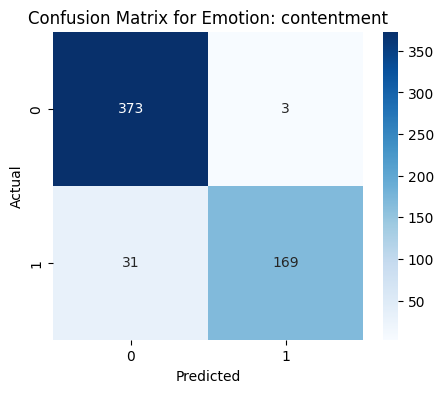

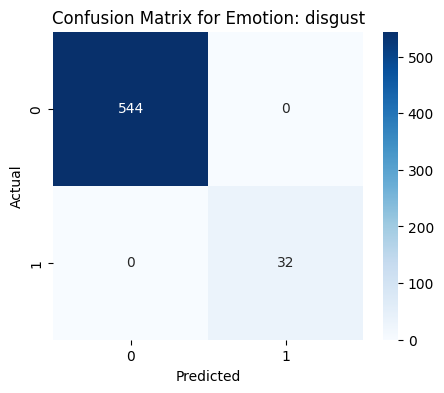

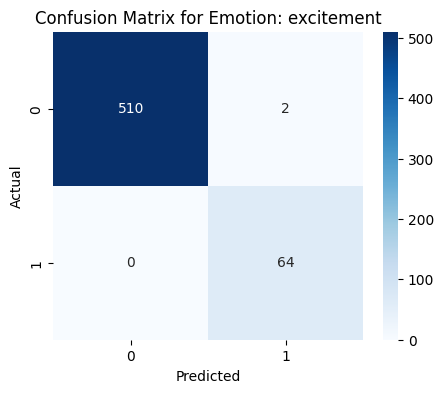

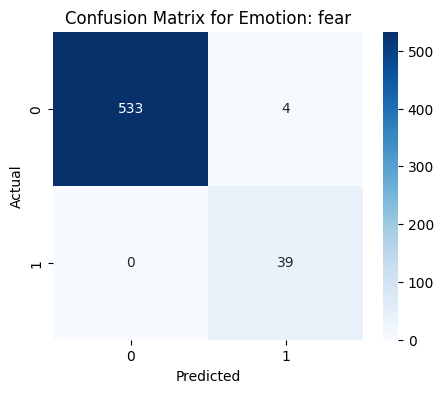

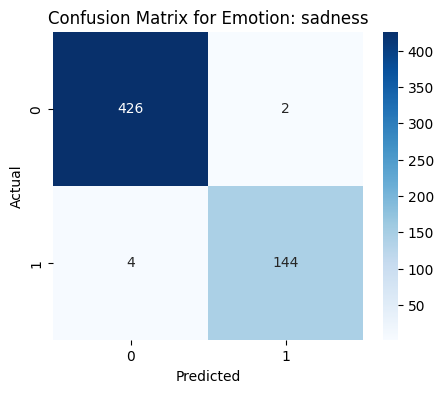

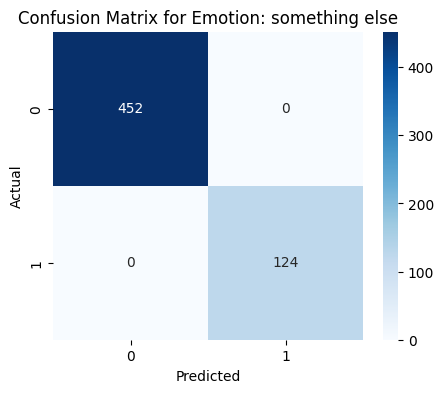

Train Set: Loss: 0.0559, Accuracy: 0.9869


In [30]:
test_loss, test_accuracy = evaluate_classification(alexNetModel, criterion, test_loader)
print(f'Train Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')

In [31]:
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Definisanje slojeva
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # Prvi konvolucioni sloj
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # Drugi konvolucioni sloj
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Treći konvolucioni sloj
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling sloj
        
        # Fully connected slojevi
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # 128 filtera * 28*28 veličina slike posle konvolucija
        self.fc2 = nn.Linear(512, num_classes)  # Izlaz sa brojem klasa (emocija)
        
        # Dropout za regularizaciju
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # Flatten slika u vektor
        x = x.view(-1, 128 * 28 * 28)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [32]:
num_classes = emotions_encoded.shape[1] 
customCnnModel = CustomCNN(num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customCnnModel.parameters(), lr=0.001)

In [33]:
train_losses, train_accuracies, val_losses, val_accuracies = train_classification(
    customCnnModel, criterion, optimizer, number_of_epochs=10, 
    train_loader=train_loader, validation_loader=val_loader
)

Epoch [1/10], Train Loss: 0.2965, Train Accuracy: 0.9005
Epoch [1/10], Validation Loss: 0.1703, Validation Accuracy: 0.9475
Epoch [2/10], Train Loss: 0.1540, Train Accuracy: 0.9486
Epoch [2/10], Validation Loss: 0.1354, Validation Accuracy: 0.9552
Epoch [3/10], Train Loss: 0.1233, Train Accuracy: 0.9558
Epoch [3/10], Validation Loss: 0.1054, Validation Accuracy: 0.9626
Epoch [4/10], Train Loss: 0.0979, Train Accuracy: 0.9639
Epoch [4/10], Validation Loss: 0.0930, Validation Accuracy: 0.9670
Epoch [5/10], Train Loss: 0.0811, Train Accuracy: 0.9703
Epoch [5/10], Validation Loss: 0.0775, Validation Accuracy: 0.9734
Epoch [6/10], Train Loss: 0.0640, Train Accuracy: 0.9761
Epoch [6/10], Validation Loss: 0.0719, Validation Accuracy: 0.9730
Epoch [7/10], Train Loss: 0.0578, Train Accuracy: 0.9783
Epoch [7/10], Validation Loss: 0.0647, Validation Accuracy: 0.9761
Epoch [8/10], Train Loss: 0.0514, Train Accuracy: 0.9811
Epoch [8/10], Validation Loss: 0.0591, Validation Accuracy: 0.9811
Epoch [9

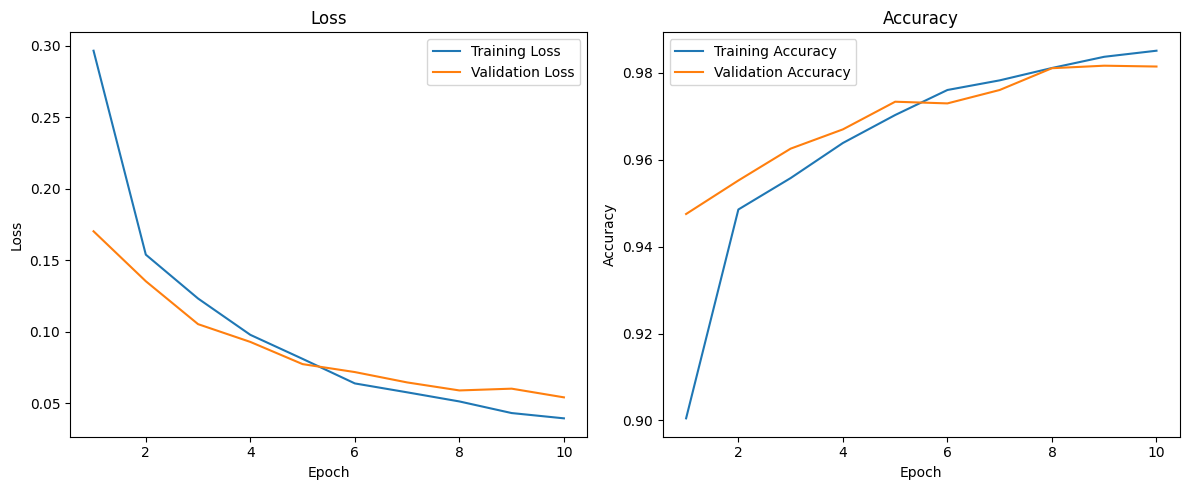

In [34]:
plot_classification(train_losses, train_accuracies, val_losses, val_accuracies)

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x7f719476d370>
Accuracy: 0.9062
Precision: 0.9797
Recall: 0.9714
F1 Score: 0.9747


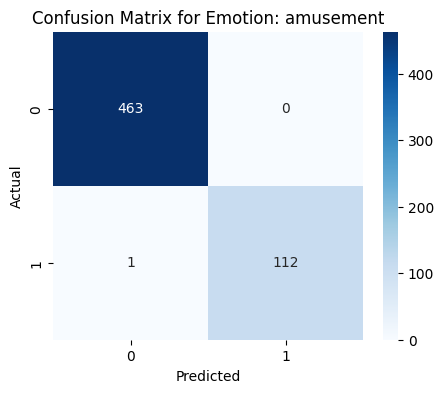

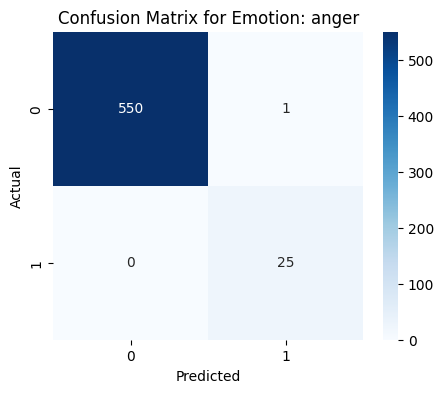

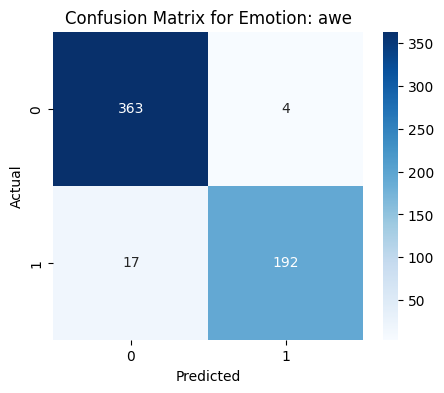

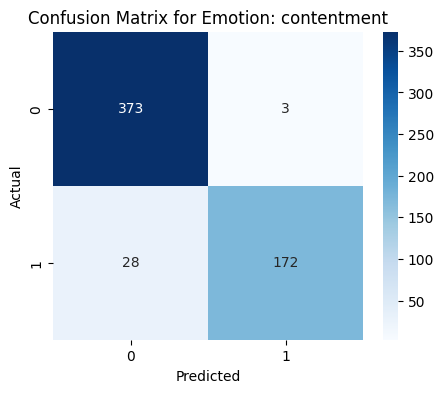

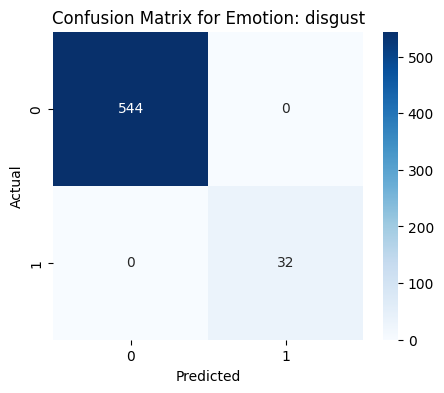

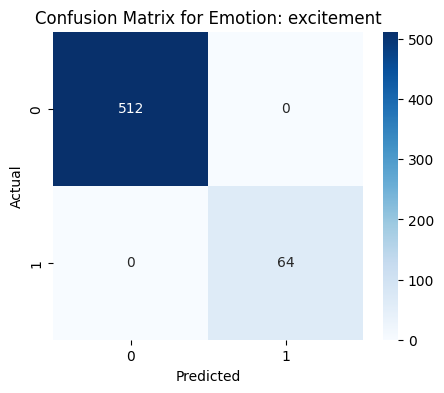

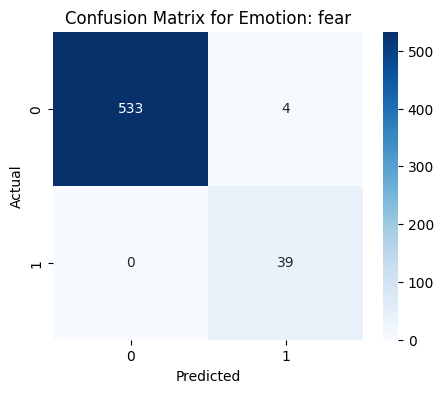

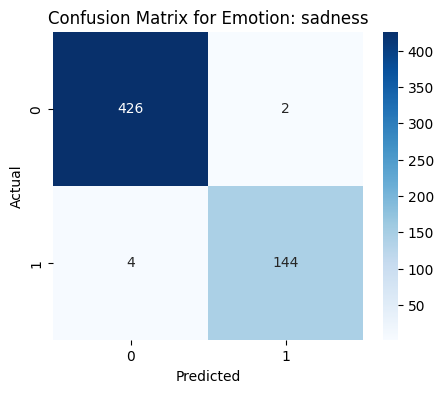

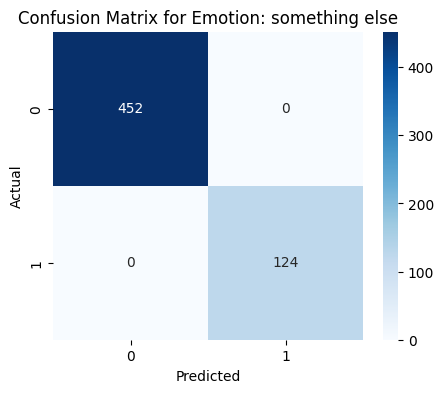

Train Set: Loss: 0.0576, Accuracy: 0.9877


In [35]:
test_loss, test_accuracy = evaluate_classification(alexNetModel, criterion, test_loader)
print(f'Train Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')

In [36]:
"""Cuvanje podataka"""
model_filename = 'models/modelResNet.model'

with open(model_filename, 'wb') as pickle_file:
    pickle.dump(modelResNet, pickle_file)

model_filename = 'models/alexNetModel.model'

with open(model_filename, 'wb') as pickle_file:
    pickle.dump(alexNetModel, pickle_file)

model_filename = 'models/customCnnModel.model'

with open(model_filename, 'wb') as pickle_file:
    pickle.dump(customCnnModel, pickle_file)